# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1Fw6VxUqmLcoc0srMQeFr6UegYFRMFDX8?usp=sharing


In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch #total epoch-> total number of samples
    loss = float(total_loss) / (i + 1) #i is batch iteration
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')#best llocation fir the legend
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()



## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170498071/170498071 [00:11<00:00, 15367773.09it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

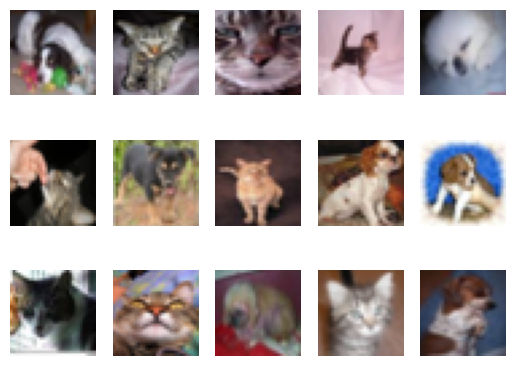

In [63]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    #print(img.shape)
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)#number of rows and columns in the grid
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

Answer: We have

*   Cat Train Count: 4018, Dog Train Count: 3982
*   Cat Val Count: 982, Dog Val Count: 1018
*   Cat Test Count: 1000, Dog Test Count: 1000

That means we have 8000 training examples, 2000 validation examples, and 2000 test examples.

In [ ]:
cat_test = 0
dog_test = 0
cat_train = 0
dog_train = 0
cat_val = 0
dog_val = 0

for images, labels in train_loader:
    if labels == 3:
        cat_train += 1
    else:
        dog_train += 1
print("Cat Train Count:", cat_train, "Dog Train Count:", dog_train)

for images, labels in val_loader:
    if labels == 3:
        cat_val += 1
    else:
        dog_val += 1
print("Cat Val Count:", cat_val, "Dog Val Count:", dog_val)

for images, labels in test_loader:
    if labels == 3:
        cat_test += 1
    else:
        dog_test += 1
print("Cat Test Count:", cat_test, "Dog Test Count:", dog_test)


Cat Train Count: 4018 Dog Train Count: 3982
Cat Val Count: 982 Dog Val Count: 1018
Cat Test Count: 1000 Dog Test Count: 1000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

Answer: The validation set plays a crucial role in training our model. It serves multiple purposes: firstly, it allows us to compare different models and choose the best one based on its performance on unseen data. Secondly, it helps us fine-tune the model's hyperparameters to achieve optimal results. Moreover, the validation set helps us identify and prevent overfitting, a situation where the model becomes too specialized in the training set, resulting in low training set loss/error but poor generalization to new data. If we solely rely on the training set loss/error to evaluate our models, we risk selecting models that perform well on the training data but struggle with new data. The validation set provides a more accurate and unbiased assessment of our model's performance on unseen data, enabling us to make better decisions during the training process.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module): #nn.Modlue- class for CNN
# consisting 2 convolutional layers each followed by a max pooling layer
#These layers are responsible for extracting features from the input image.
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)#kernal 5x5
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)#kernal 5x5
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)#input, output, kernal sizes
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

Answers:

In small_net, we have

 3 * 5 * 3 * 3 + 5 + 5 * 7 * 7 + 1

 =135 + 5 + 245 + 1 = 386 parameters.

In large_net, we have

5 x 3 x 5 x 5 + 5 + 10 x 5 x 5 x 5 + 10 + 32 x 250 + 32 + 32 + 1

= 375 + 1250 + 8000 + 80 = 9705 parameters.

In [ ]:
small = 0
large = 0
for param in small_net.parameters():
  print(param.shape)
  small += param.numel()
print(small)
print()
for param in large_net.parameters():
  print(param.shape)
  large += param.numel()
print(large)



torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
386

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    #Stochastic Gradient Descent (SGD)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        #print("val_loader", val_loader)#hhhhhhhhhhhhhhhhhere
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

Answer: The default values of the parameters batch_size is 64, learning_rate is 0.01, and num_epochs is 30.

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

Answer: The follwing files will be written to disk

1. 5 small_bs64_lr0.01_epoch#.pth: This file contains the state dictionary of the small_net model after every epoch of training. It includes the trained parameters (weights and biases) of the model.
2. {model_path}_train_err.csv: This file contains the training error values for each epoch. It is a CSV file where each row represents the training error for a specific epoch.
3.{model_path}_train_loss.csv: This file contains the training loss values for each epoch. Similar to the previous file, it is a CSV file where each row represents the training loss for a specific epoch.
4.{model_path}_val_err.csv: This file contains the validation error values for each epoch. It is a CSV file where each row represents the validation error for a specific epoch.
5. {model_path}_val_loss.csv: This file contains the validation loss values for each epoch. Similar to the previous file, it is a CSV file where each row represents the validation loss for a specific epoch.

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

Answer: The small network took 156.78 seconds and the large network took 166.88 seconds.

The larger network takes longer to train because it has more parameters and more complex computations compared to the smaller network.

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_net(small_net)
print()
print()
print()
train_net(large_net)

print("The small network took 156.78 seconds")
print("The large network took 166.88 seconds")
print()
print()

Files already downloaded and verified
Files already downloaded and verified
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f2343368040>
Epoch 1: Train err: 0.418625, Train loss: 0.670397786617279 |Validation err: 0.3815, Validation loss: 0.6553246229887009
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f2343368040>
Epoch 2: Train err: 0.36075, Train loss: 0.6366503753662109 |Validation err: 0.353, Validation loss: 0.6372593212872744
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f2343368040>
Epoch 3: Train err: 0.335625, Train loss: 0.6162112917900086 |Validation err: 0.3455, Validation loss: 0.6179153621196747
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f2343368040>
Epoch 4: Train err: 0.326125, Train loss: 0.6007917432785034 |Validation err: 0.3585, Validation loss: 0.6256148349493742
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f2343368040>
Epoch 5: Train err: 0.312, Train loss: 0.5890052781105

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

Small Network:


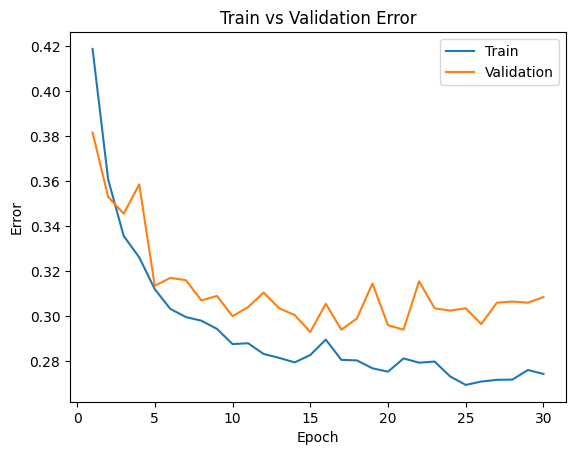

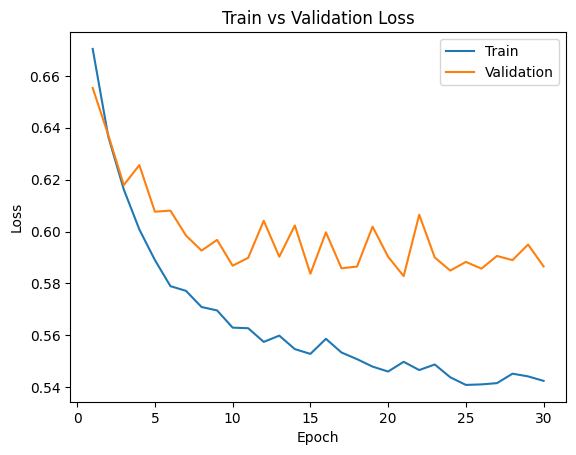

Large Network:


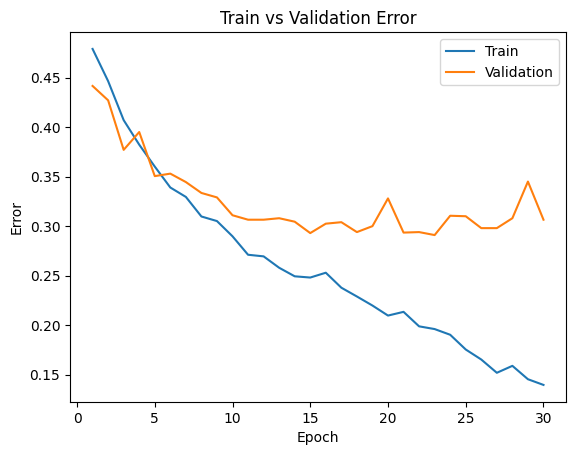

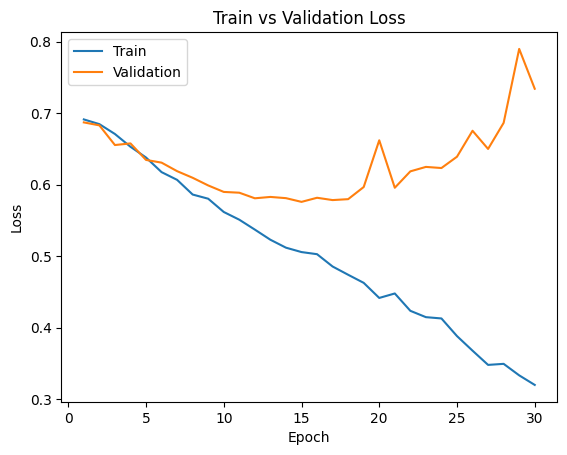

In [39]:
small_model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)

print("Small Network:")
plot_training_curve(small_model_path)
print("Large Network:")
plot_training_curve(large_model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

Answer: Both the large and small networks show a **consistent decrease in** training error and loss throughout the training process, as observed in their respective **training curves**. This indicates that the models are improving their performance on the training data over time.

However, when we examine the **validation curves**, a noticeable change occurs. After approximately **10 epochs for the large network and 15 epochs for the small network**, the validation curves start to deviate from the consistent decrease observed in the training curves. In the case of the large network, the validation loss begins to increase, suggesting that the model is **overfitting**.

Overfitting occurs when a model becomes too specialized in capturing the nuances of the training data, leading to a decrease in its ability to generalize to unseen data. This is reflected in the increasing validation loss for the large network.

On the other hand, the small network exhibits a higher training error of 0.28 compared to the large network's 0.15. However, both networks achieve a similar best validation error score of 0.30, indicating that they perform equally well in terms of generalization.

To summarize, while both networks show consistent improvement on the training data, the large network experiences overfitting, as evidenced by the increasing validation loss. The small network, despite having a higher training error, demonstrates better generalization ability with a similar best validation error score.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

answer: Lowering the learning rate to 0.001 had several effects on the training process:

- Increased training time: The model took 182.14 seconds to train with the lowered learning rate, which is longer than the original default learning rate of 0.01, which took 166.88 seconds.

- Smoother and more gradual decrease in error/loss: The training curve for both the training and validation error/loss showed a smoother and more gradual decrease. This indicates that the model was making smaller updates to its parameters, resulting in a more refined optimization process.

- Avoided overfitting: Unlike the original large_net, which started to exhibit signs of overfitting after approximately 10 epochs, the model trained with the lowered learning rate did not show overfitting within the 30 epochs.

Files already downloaded and verified
Files already downloaded and verified
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f233aeb3910>
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f233aeb3910>
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f233aeb3910>
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f233aeb3910>
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f233aeb3910>
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |

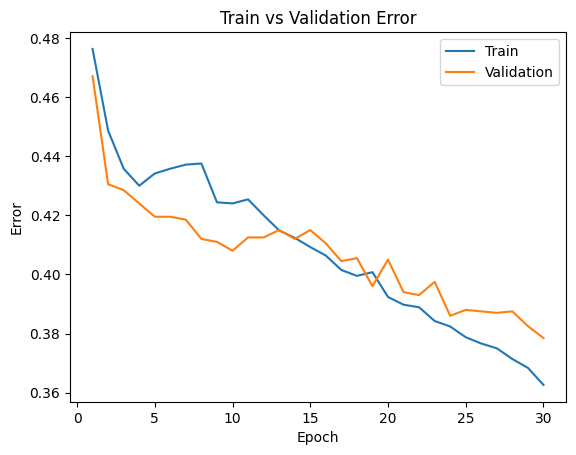

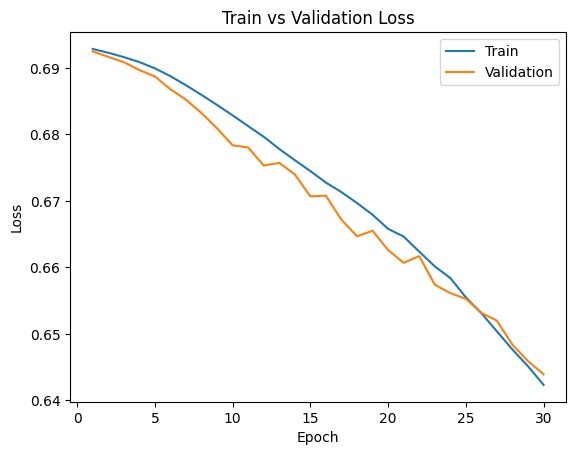

In [40]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate = 0.001)
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)

plot_training_curve(large_model_path)


### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Answer: Increasing the learning rate to 0.1 had several effects on the training process:

- Similar training time: The model trained with a learning rate of 0.1 took 167.49 seconds, which is comparable to the original default learning rate of 0.01, which took 166.88 seconds.

- Oscillations and instability: As the training progressed, the training and validation error/loss curves exhibited more frequent oscillations and instability compared to the default learning rate. The model's performance became more sensitive to the learning rate, leading to larger fluctuations in the loss values.

- Indications of overfitting: Starting from the 5th epoch, the validation error/loss began to increase, suggesting that the model quickly overfits the training data.

Files already downloaded and verified
Files already downloaded and verified
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d5f8490>
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d5f8490>
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d5f8490>
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d5f8490>
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d5f8490>
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100

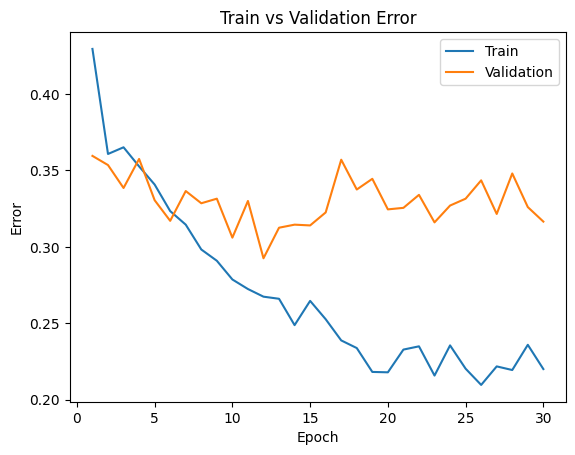

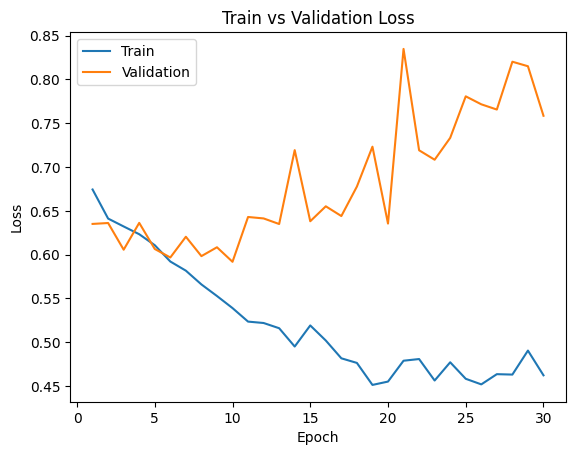

In [41]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.1)
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)

plot_training_curve(large_model_path)

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Answer: Increasing the batch_size to 512 had several effects on the training process:
- Shorter Training time: The model trained with a batch size of 512 took 146.35 seconds, which is shorter than the original default batch size of 64, which took 166.88 seconds. By processing more samples in parallel during each iteration, the model can complete computations faster, resulting in shorter training times.

- Smoother training curve: Increasing the batch size resulted in a smoother training curve. With larger batches, the model updates its parameters based on a larger number of samples at once, leading to a more stable gradient estimation.



Files already downloaded and verified
Files already downloaded and verified
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d5fb610>
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d5fb610>
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d5fb610>
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d5fb610>
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d5fb610>
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 

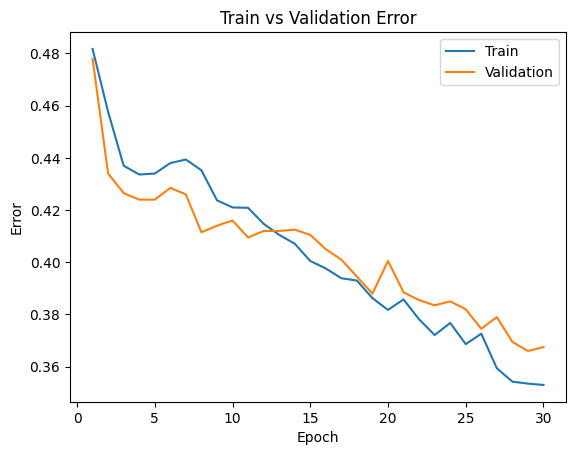

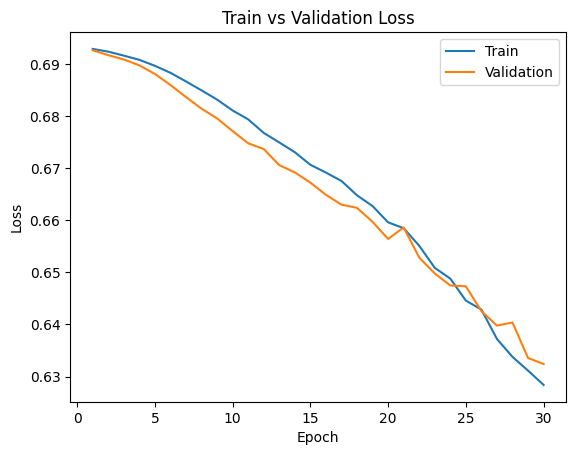

In [42]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.01, batch_size = 512)
large_model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)

plot_training_curve(large_model_path)

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Answer: Decreasing the batch_size to 16 had several effects on the training process:
- Increased training time: The model took 221.66 seconds to train with a smaller batch size of 16, which is longer than the default batch size of 64.

- imited improvement in validation error: The validation error remained relatively stable between 0.3 and 0.4 throughout the training process. There wasn't a significant improvement compared to the default batch size.

- Unstable validation loss: The validation loss started from 0.7 and increased to 1.4 after 30 epochs. This indicates that the model struggled to generalize well to unseen data and may have suffered from overfitting or instability in the learning process.

Files already downloaded and verified
Files already downloaded and verified
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d4b4460>
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d4b4460>
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d4b4460>
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d4b4460>
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d4b4460>
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517

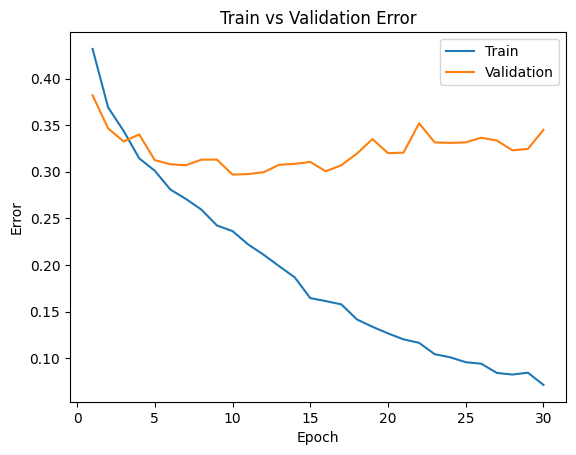

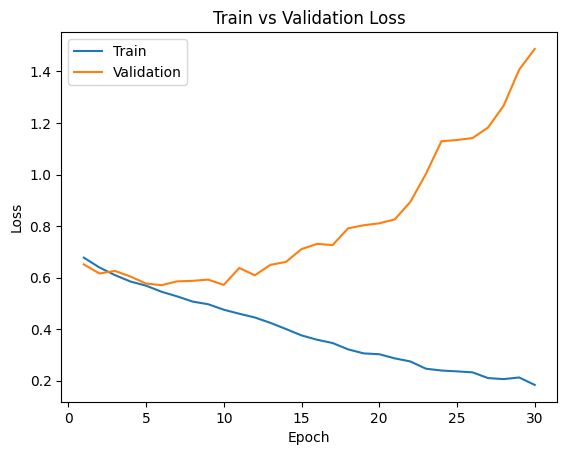

In [43]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.01, batch_size = 16)
large_model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)

plot_training_curve(large_model_path)

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

Answer: (large_net, learning_rate = 0.001, batch_size = 128, num_epochs = 25)

The choice of using the train_net function with large_net, learning_rate=0.001, batch_size=128, and num_epochs=25 is made with the following justifications:

- Network Selection: The large_net is selected as it has shown promising results in previous experiments, and it has the potential to improve the validation accuracy.

- Learning Rate: A lower learning rate of 0.001 is chosen to ensure more precise weight updates during training and avoid overshooting the optimal solution.

- Batch Size: A batch size of 128 is selected as it strikes a balance between computational efficiency and stability, allowing for efficient parallelism and noise reduction in gradient estimation.

- Number of Epochs: By training for 25 epochs, the model has more opportunities to learn and improve its performance. This helps in mitigating the risk of underfitting and allows for better convergence.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d336170>
Epoch 1: Train err: 0.4955, Train loss: 0.6937775630799551 |Validation err: 0.4915, Validation loss: 0.6921610310673714
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d336170>
Epoch 2: Train err: 0.471375, Train loss: 0.6906678742832608 |Validation err: 0.434, Validation loss: 0.6885901391506195
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d336170>
Epoch 3: Train err: 0.453375, Train loss: 0.6891775907032074 |Validation err: 0.439, Validation loss: 0.6870098151266575
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d336170>
Epoch 4: Train err: 0.446625, Train loss: 0.6881594449754745 |Validation err: 0.44, Validation loss: 0.6856352612376213
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232d336170>
Epoch 5: Train err: 0.444625, Train loss: 0.6873583973400

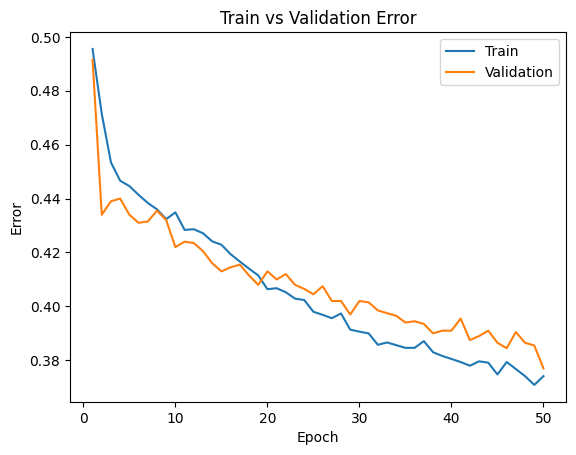

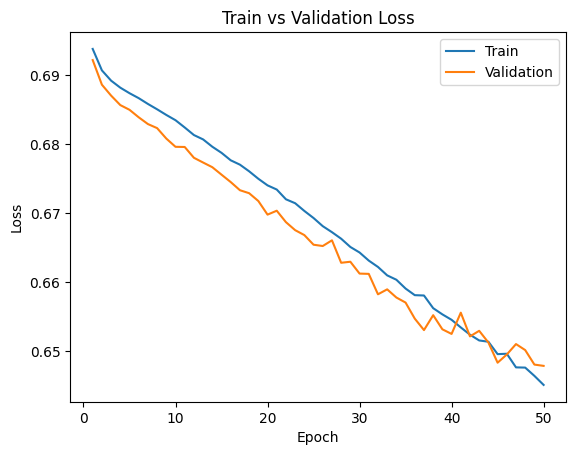

In [49]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.001, batch_size = 128, num_epochs = 50)
large_model_path = get_model_name("large", batch_size=128, learning_rate=0.001, epoch=49)

plot_training_curve(large_model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

Answer: (large_net, learning_rate = 0.01, batch_size = 512, num_epochs = 100)

Based on the observation that training with (large_net, learning_rate = 0.001, batch_size = 128, num_epochs = 50) led to a smooth validation error curve, indicating potential underfitting, I suggest increasing the learning rate to 0.01 and increase the number of epochs to see the performance. This adjustment aims to accelerate the learning process and improve the model's ability to discover better solutions.


### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232bfa2ec0>
Epoch 1: Train err: 0.50225, Train loss: 0.6944969221949577 |Validation err: 0.491, Validation loss: 0.6927655637264252
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232bfa2ec0>
Epoch 2: Train err: 0.500875, Train loss: 0.6929911114275455 |Validation err: 0.488, Validation loss: 0.6920229494571686
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232bfa2ec0>
Epoch 3: Train err: 0.482625, Train loss: 0.6919575408101082 |Validation err: 0.468, Validation loss: 0.6912059932947159
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232bfa2ec0>
Epoch 4: Train err: 0.448125, Train loss: 0.6908427700400352 |Validation err: 0.443, Validation loss: 0.6898833364248276
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232bfa2ec0>
Epoch 5: Train err: 0.440375, Train loss: 0.689450766891

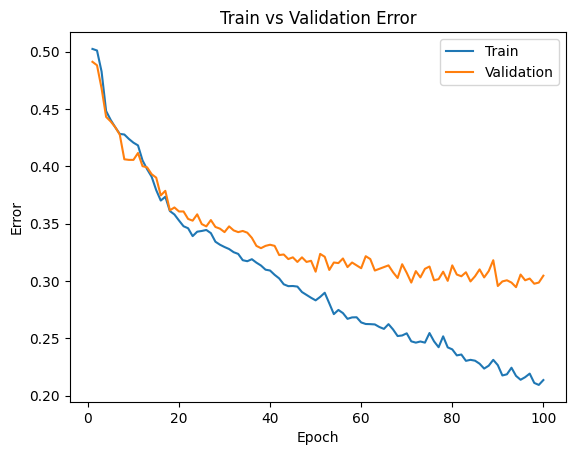

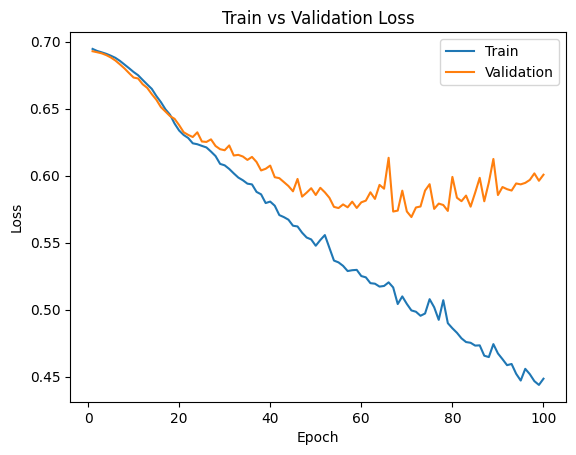

In [53]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.01, batch_size = 512, num_epochs = 100)
large_model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=99)

plot_training_curve(large_model_path)
#0.2945, 0.573

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [59]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.01, epoch=90)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

Answer:
The chosen model net = LargeNet() with batch_size=512, learning_rate=0.01, and epoch=90, has the lowest validation error and validation loss, indicating better generalization and reduced overfitting. By loading the weights from this model checkpoint using net.load_state_dict(state), the model is initialized with the learned parameters that led to the best performance on unseen data.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [60]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=256)


# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Evaluate the model on the test set
test_error,test_loss = evaluate(net, test_loader, criterion)
print(f"Test Error: {test_error:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Files already downloaded and verified
Files already downloaded and verified
Test Error: 0.2880
Test Loss: 0.5665


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.


Answer: The test classification error is expected to be higher than the validation error because the validation set is used during model training for tuning and optimizing the model's performance. The model might inadvertently "learn" specific patterns in the validation set. In contrast, the test set is unseen during training and provides a more accurate evaluation of the model's performance on new, unseen data. Therefore, the test error reflects the model's generalization ability to real-world scenarios and is typically higher than the validation error.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

Answer: We only use the test dataset at the very end to evaluate the final performance of the trained model. It is important to use the test data as little as possible because excessive use of the test set during model development can lead to biased evaluation and potentially inflated performance metrics. If we rely too heavily on the test data for making decisions or tuning the model, we risk overestimating its performance on new, unseen data. By reserving the test data for the final evaluation, we ensure a more accurate and unbiased assessment of the model's generalization capabilities.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Answer: The performance of the best CNN model and the 2-layer ANN model on classifying cat and dog images was evaluated using the test error and test loss metrics. The 2-layer ANN model achieved a test error of 0.3600 and a test loss of 0.6388, while the CNN model outperformed it with a lower test error of 0.2880 and a lower test loss of 0.5665. These results indicate that the CNN model performed better in distinguishing between cat and dog images compared to the 2-layer ANN model.

Files already downloaded and verified
Files already downloaded and verified
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232c946590>
Epoch 1: Train err: 0.45475, Train loss: 0.686979127308679 |Validation err: 0.4125, Validation loss: 0.6776074320077896
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232c946590>
Epoch 2: Train err: 0.408625, Train loss: 0.6691889810183692 |Validation err: 0.406, Validation loss: 0.6666149348020554
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232c946590>
Epoch 3: Train err: 0.39875, Train loss: 0.6617650522126092 |Validation err: 0.406, Validation loss: 0.6625422388315201
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232c946590>
Epoch 4: Train err: 0.394625, Train loss: 0.6566719743940566 |Validation err: 0.4015, Validation loss: 0.6587135195732117
val_loader <torch.utils.data.dataloader.DataLoader object at 0x7f232c946590>
Epoch 5: Train err: 0.38675, Train loss: 0.6528310993361

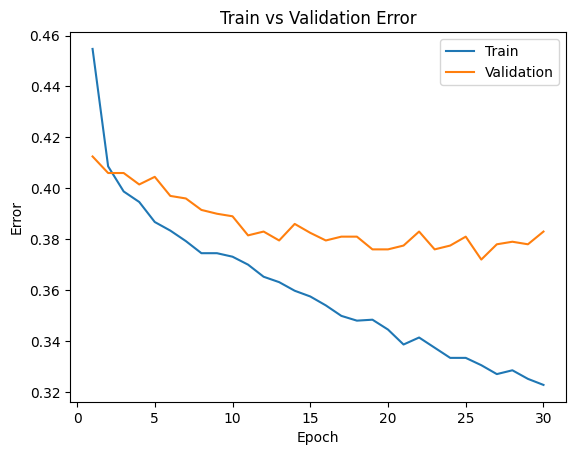

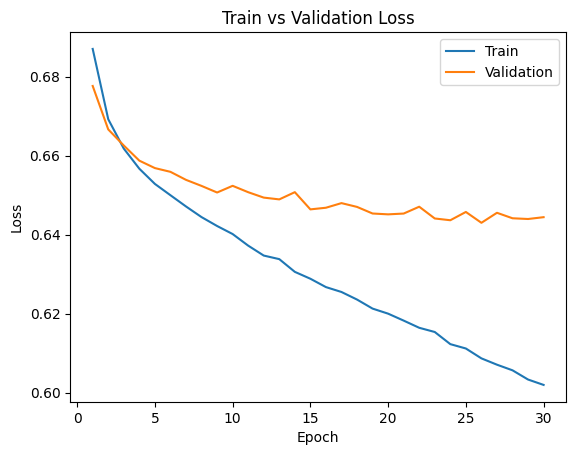

In [71]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.name = "ANN"
        self.layer1 = nn.Linear(32 * 32 * 3, 30)
        self.layer2 = nn.Linear(30, 1)

    def forward(self, img):
        flattened = img.view(-1, 32 * 32 * 3)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

ANN_model = ANN()
train_net(ANN_model, batch_size=128, learning_rate=0.001, num_epochs=30)
ANN_model_path = get_model_name("ANN", batch_size=128, learning_rate=0.001, epoch=29)
plot_training_curve(ANN_model_path)

In [72]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=128)


# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Evaluate the model on the test set
test_Error,test_Loss = evaluate(ANN_model, test_loader, criterion)
print(f"Test Error: {test_Error:.4f}")
print(f"Test Loss: {test_Loss:.4f}")

Files already downloaded and verified
Files already downloaded and verified
Test Error: 0.3600
Test Loss: 0.6388
